# **Anomaly Detection using MISC-OD**

The `MISC-OD` (Mutual Information and Reduced Spectral Clustering - Outlier Detection) algorithm was evaluated in comparison to the Local Outlier Factor (LOF) and Isolation Forest methods for novelty detection using a version of the `Wisconsin Breast Cancer (Diagnostics) dataset`.

For detailed insights into this methodology, please refer to the following reference: [*A Novel Unsupervised Outlier Detection Algorithm Based on Mutual Information and Reduced Spectral Clustering*](https://www.mdpi.com/2079-9292/12/23)

---


## Results

MISC-OD had a high ROC comparable to Isolation Forest, albeit slightly lower. Despite this, its AUPRC and Average Precision were higher. LOF had higher AUPRC and AP to MISC-OD but had a lower ROC. In conclusion, each model demonstrated merits depending on the evaluation metric.


| Model    | ROC   | AUPRC   | AP    |
|----------|-------|-------|-------|
| MISC-OD  | 0.956 | 0.811 | 0.713 |
| LOF      | 0.901 | 0.857 | 0.735 |
| IsoForest| 0.967 | 0.670 | 0.681 |


# Execution

## Libraries

In [72]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, f1_score, auc, average_precision_score, roc_curve
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

from imblearn.over_sampling import RandomOverSampler, SMOTE, ADASYN
from imblearn.under_sampling import RandomUnderSampler, TomekLinks
from imblearn.combine import SMOTETomek

from xgboost import XGBClassifier

## Data Loading and Preprocessing

The original Wisconsin-Breast Cancer (Diagnostics) dataset (WBC) from UCI machine learning repository is a classification dataset, which records the measurements for breast cancer cases. There are two classes, benign and malignant. The malignant class of this dataset is downsampled to 21 points, which are considered as outliers, while points in the benign class are considered inliers.

---

Data retrieved from: <br>
[Stony Brook University ODDS Library: Breast Cancer Wisconsin (Original) Dataset](https://odds.cs.stonybrook.edu/wbc/) (Accessed May 14, 2024)

In [4]:
# Load 
df = pd.read_csv('credit_card.csv')

display(df.head(3).round(3))

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,-0.612,-0.770,-0.150,-0.225,2.029,-2.020,0.292,-0.523,0.358,0.070,...,-0.075,0.046,0.381,0.023,-2.221,-0.201,0.067,0.221,1.79,0
1,-0.815,1.319,1.329,0.027,-0.285,-0.654,0.322,0.436,-0.704,-0.601,...,-0.129,-0.369,0.091,0.401,-0.261,0.081,0.162,0.059,1.98,0
2,-0.318,1.119,0.970,-0.127,0.570,-0.532,0.706,-0.065,-0.463,-0.528,...,-0.305,-0.775,-0.124,-0.496,-0.018,0.122,0.249,0.093,0.89,0


In [61]:
# Split
X = df.iloc[:, :-1]
y = df.iloc[:, -1]

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    train_size=0.8,
                                                    stratify=y,
                                                    random_state=42)

In [65]:
# Scale
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

## EDA

Not fraud:  28432
Fraud:      49


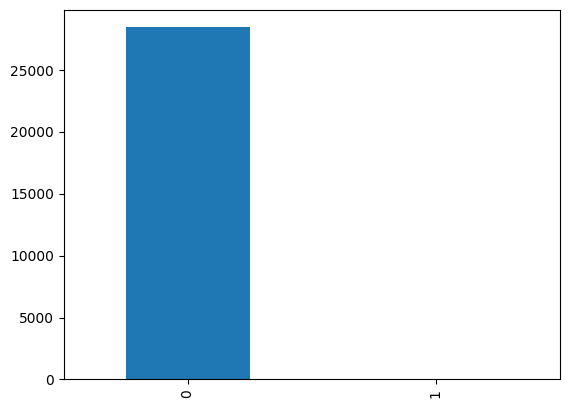

In [18]:
print(f"Not fraud:  {df.Class.value_counts()[0]}")
print(f"Fraud:      {df.Class.value_counts()[1]}")
df['Class'].value_counts().plot.bar();

There is weak correlation between the features as the data has already been preprocessed using dimensionality reduction, namely Principal Component Analysus (PCA). PCA achieves this by transforming the original data into a set of linearly uncorrelated variables known as principal components. These components are ordered so that the first few retain most of the variation present in all of the original variables. As a result, the redundancy and correlation within the data are minimized, which is evident in the weak correlations between the transformed features. This can be beneficial for many machine learning algorithms that perform better on datasets where the features are not closely related, reducing issues like multicollinearity.

The features in the original dataset are components.

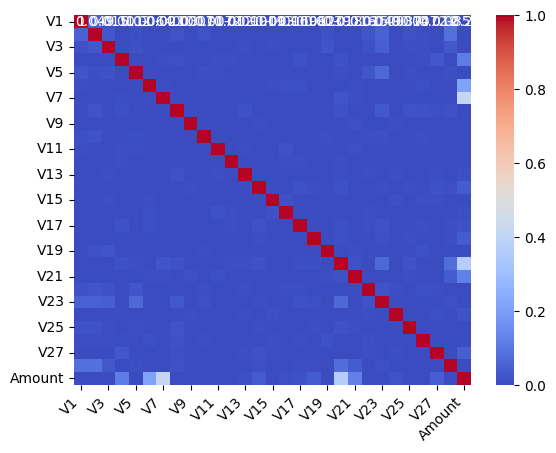

In [23]:
sns.heatmap(X.corr(), vmin=0, vmax=1, cmap='coolwarm', annot=True)
plt.xticks(rotation=45, ha='right')
ax = plt.gca()

plt.show()

## Baseline

### PCC

Due to the highly imbalanced nature of the data, the PCC metric is nonsensical and not useful. Given that the goal is in identifying fraudulent transactions, precision or recall scores would be more helpful as these metrics exclude true-negatives from the scoring calculation.

In [29]:
PCC = sum((y.value_counts() / len(y))**2)
print("Proportion Chance Criterion = {}%".format(100*PCC))
print("1.25*Proportion Chance Criterion = {}%".format(1.25*100*PCC))

Proportion Chance Criterion = 99.65650294452615%
1.25*Proportion Chance Criterion = 124.57062868065769%


## Model x Resampling Method Evaluation

### Set-Up

In [76]:
seed = 42
np.random.seed(seed)

class NoResampling:
    def fit_resample(self, X, y):
        return X, y

    def fit(self, X, y):
        return self

    def set_params(self, **params):
        return self

resampling_methods = {
    'Original': NoResampling(),
    'ROS': RandomOverSampler(),
    'RUS': RandomUnderSampler(),
    'Tomek': TomekLinks(),
    'SMOTE': SMOTE(),
    'ADASYN': ADASYN(),
    'SMOTETomek': SMOTETomek()
}

models = {
    'knn': KNeighborsClassifier(),
    'logistic_l1': LogisticRegression(penalty='l1', solver='liblinear', max_iter=3000, random_state=seed),
    'logistic_l2': LogisticRegression(penalty='l2', dual=False, max_iter=3000, random_state=seed),
    'xgb': XGBClassifier(random_state=seed),
    'rf': RandomForestClassifier(random_state=seed),
}

param_grid = {
    'knn': {
        'n_neighbors': [3, 5, 10]
    },
    'logistic_l1': {
        'C': [0.01, 0.1, 1]
    },
    'logistic_l2': {
        'C': [0.01, 0.1, 1]
    },
    'xgb': {
        'n_estimators': [100, 200],
        'max_depth': [5, 10],
        'learning_rate': [0.01, 0.1]
    },
    'rf': {
        'n_estimators': [100, 150],
        'max_depth': [10, 20],
    }
}

cv = StratifiedKFold(n_splits=3)

### Gridsearch

In [77]:
# Initialize to store results
results = []
best_models_dict = {}

for resample_method, resampler in resampling_methods.items():
    X_resampled, y_resampled = resampler.fit_resample(X_train, y_train)

    for model_name, model in models.items():
        # Name
        combo_name = f'{model_name}-{resample_method}'

        # GridSearchCV
        grid_search = GridSearchCV(model, 
                                   param_grid[model_name],
                                   cv=cv,
                                   n_jobs=-1,
                                   scoring='f1', 
                                   return_train_score=True)
        grid_search.fit(X_resampled, y_resampled)
        best_model = grid_search.best_estimator_

        # Get Train Val Metrics
        idx = grid_search.best_index_
        fit_time = grid_search.cv_results_['mean_fit_time'][idx]
        train_f1 = grid_search.cv_results_['mean_train_score'][idx]
        val_f1 = grid_search.cv_results_['mean_test_score'][idx]

        # Get Test Metrics
        y_pred = best_model.predict(X_test)
        y_pred_proba = best_model.predict_proba(X_test)[:, 1]
        test_ap = average_precision_score(y_test, y_pred_proba)
        fpr, tpr, thr = roc_curve(y_test, y_pred_proba)
        test_roc = auc(fpr, tpr)
        test_f1 = f1_score(y_test, y_pred)
        test_auprc = average_precision_score(y_test, y_pred_proba)
        test_accuracy = accuracy_score(y_test, y_pred)

        # Collect result
        result = {'name': combo_name,
                  'fit_time': fit_time,
                  'train_f1': train_f1,
                  'val_f1': val_f1,
                  'test_f1': test_f1,
                  'test_roc': test_roc,
                  'test_avgPrecision': test_ap,
                  'test_accuracy': test_accuracy}

        results.append(result)

Progress: 2.9%, Last: knn-Original

Progress: 100.0%, Last: rf-SMOTETomekOTETomek

### Evaluation

In [78]:
df_results = pd.DataFrame(results)
# df_results.to_csv('results.csv', index=False)

In [84]:
df_results = df_results.sort_values(by=['test_roc'], ascending=False)
df_results.round(3).head(10)

,name,fit_time,train_f1,val_f1,test_f1,test_roc,test_avgPrecision,test_accuracy
23,xgb-SMOTE,0.641,1.000,1.000,0.632,0.976,0.709,0.999
28,xgb-ADASYN,0.641,1.000,0.939,0.600,0.964,0.645,0.999
12,logistic_l2-RUS,0.005,1.000,0.903,0.053,0.954,0.294,0.956
29,rf-ADASYN,11.321,0.994,0.914,0.200,0.952,0.591,0.989
33,xgb-SMOTETomek,0.739,1.000,1.000,0.632,0.941,0.713,0.999
34,rf-SMOTETomek,39.491,1.000,1.000,0.750,0.926,0.692,0.999
13,xgb-RUS,0.082,0.980,0.894,0.030,0.918,0.161,0.909
8,xgb-ROS,0.482,1.000,1.000,0.600,0.912,0.693,0.999
4,rf-Original,6.855,1.000,0.723,0.667,0.903,0.711,0.999
14,rf-RUS,0.143,1.000,0.931,0.068,0.901,0.727,0.961


## Final Result

In [28]:
display(pd.DataFrame(baseline_data))

,Model,roc,auprc,ap
0,LOF,0.901961,0.857421,0.734893
1,IsoForest,0.966653,0.670314,0.680550
2,MISC-OD,0.956182,0.810847,0.712963


## **Acknowledgements**

Huang, Y., Liu, W., Li, S., Guo, Y., & Chen, W. (2023). *A Novel Unsupervised Outlier Detection Algorithm Based on Mutual Information and Reduced Spectral Clustering*. *Electronics*, 12(23). MDPI AG. Available at [https://www.mdpi.com/2079-9292/12/23](https://www.mdpi.com/2079-9292/12/23) (accessed May 14, 2024).

Wolberg,William, Mangasarian,Olvi, Street,Nick, and Street,W.. (1995). Breast Cancer Wisconsin (Diagnostic). UCI Machine Learning Repository. https://doi.org/10.24432/C5DW2B.

---

*The original dataset was downloaded from Stony Brook University's ODDS library:* <br>
*Rayana, S. (2016). ODDS Library [http://odds.cs.stonybrook.edu]. Stony Brook, NY: Stony Brook University, Department of Computer Science.*
<br>

Data retrieved from: <br>
[Stony Brook University ODDS Library: Breast Cancer Wisconsin (Original) Dataset](https://odds.cs.stonybrook.edu/wbc/) (Accessed May 14, 2024)